## Download the dataset

In [3]:
import os
import zipfile

zip_url = "https://zenodo.org/records/11661820/files/T1.train_dev.zip?download=1"
zip_path = "T1.train_dev.zip"
extracted_folder = "T1.train_dev"

# Download with system wget (Jupyter syntax)
if not os.path.exists(zip_path):
    print("Downloading dataset...")
    !wget -O $zip_path "$zip_url"
else:
    print("ZIP file already exists.")

# Extract if not already extracted
if not os.path.exists(extracted_folder):
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_folder)
    print("Extraction complete.")
else:
    print("Dataset already extracted.")

ZIP file already exists.
Extracting dataset...
Extraction complete.


In [17]:
!pip install pandas
!pip install matplotlib
!pip install quantificationlib
!pip install scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd

dataset = pd.read_csv('T1.train_dev/T1/public/training_data.txt')

print(dataset)

      label        0       1        2        3         4        5        6  \
0         1  1.10940 -1.5099  0.26001 -0.62786 -0.356860  0.32722 -1.00670   
1         1  0.94284 -1.3486  0.35036 -0.68159 -0.046541  0.45244 -1.25130   
2         1  0.94738 -1.4309  0.22982 -0.84249 -0.414650  0.56810 -1.38980   
3         1  1.02150 -1.4751  0.29282 -0.66289 -0.003578  0.37674 -1.20800   
4         1  1.07030 -1.1924  0.23481 -0.54509 -0.228920  0.27440 -1.00250   
...     ...      ...     ...      ...      ...       ...      ...      ...   
4995      1  0.90753 -1.5766  0.13906 -1.00270 -0.210630  0.51940 -1.02110   
4996      1  1.01900 -1.4851  0.43065 -0.75151 -0.089563  0.43897 -1.10860   
4997      0  1.00370 -1.0824  0.27074 -0.88833 -0.337040  0.63238 -1.10940   
4998      1  0.99343 -1.4536  0.36971 -1.16970  0.099819  0.40902 -0.84970   
4999      1  0.88026 -1.3862  0.42127 -0.87045 -0.328340  0.55201 -0.46403   

           7         8  ...      246       247       248      2

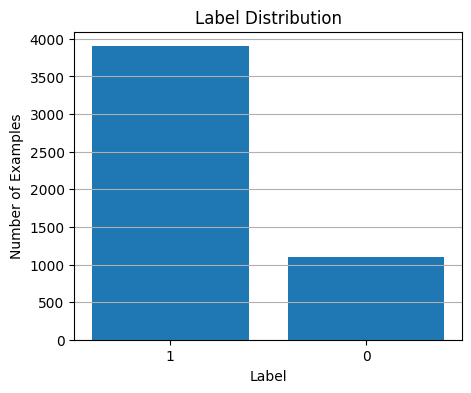

In [ ]:
import matplotlib.pyplot as plt

# Count examples per label
label_counts = dataset['label'].value_counts()

# Plot
plt.figure(figsize=(5, 4))
plt.bar(label_counts.index.astype(str), label_counts.values)
plt.xlabel('Label')
plt.ylabel('Number of Examples')
plt.title('Label Distribution')

plt.grid(axis='y')
plt.show()


## Vamos a cuantificar con el método más simple Clasificar y Contar

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np

X = dataset.drop(columns=["label"]).values
y = dataset["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Train: {len(y_train)} ejemplos (Proporción positivos: {np.mean(y_train):.2f}) | Test: {len(y_test)} ejemplos (Proporción positivos: {np.mean(y_test):.2f})")

Train: 3500 ejemplos (Proporción positivos: 0.78) | Test: 1500 ejemplos (Proporción positivos: 0.78)


In [35]:
from sklearn.metrics import accuracy_score

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
cc_prevalence = np.mean(y_pred)
true_prevalence = np.mean(y_test)

print(f"Clasificar y contar (porcentaje postivos): {cc_prevalence:.4f}")
print(f"Porcentaje positivos real: {true_prevalence:.4f}")
print(f"Error absoluto cuantificador: {np.abs(cc_prevalence-true_prevalence):.4f}")

Clasificar y contar (porcentaje postivos): 0.8127
Porcentaje positivos real: 0.7800
Error absoluto cuantificador: 0.0327


### ¿Qué sucede si la distribución $P(y)$ cambia entre train y test?

In [ ]:
# Indices of negatives and positives in the test set
neg_indices = np.where(y_test == 0)[0]
pos_indices = np.where(y_test == 1)[0]

# Choose how many negatives and positives you want (e.g., 400 neg, 100 pos)
n_neg, n_pos = 400, 100

# Sample with replacement
sampled_neg = np.random.choice(neg_indices, size=n_neg, replace=True)
sampled_pos = np.random.choice(pos_indices, size=n_pos, replace=True)

# Combine and shuffle
bag_indices = np.concatenate([sampled_neg, sampled_pos])
np.random.shuffle(bag_indices)

# Create the bag
X_bag = X_test[bag_indices]
y_bag = y_test[bag_indices]

# Show bag size and class-1 prevalence
print(f"Número de ejemplos en test: {len(y_bag)} | Proporción positivos: {np.mean(y_bag):.1f}")

y_pred = clf.predict(X_bag)
cc_prevalence = np.mean(y_pred)
true_prevalence = np.mean(y_bag)

print(f"Clasificar y contar (porcentaje postivos): {cc_prevalence:.4f}")
print(f"Porcentaje positivos real: {true_prevalence:.2f}")
print(f"Error absoluto cuantificador: {np.abs(cc_prevalence-true_prevalence):.4f}")


Número de ejemplos en test: 500 | Proporción positivos: 0.2
Clasificar y contar (porcentaje postivos): 0.5320
Porcentaje positivos real: 0.2000
Error absoluto cuantificador: 0.3320


### Automatizando la cuantificación (quantificationlib)

In [72]:
from quantificationlib.baselines.cc import CC
from quantificationlib.metrics.multiclass import mean_absolute_error

quantifier_cc = CC(estimator_test=clf)
quantifier_cc.fit(X_train,y_train)
p_pred=quantifier_cc.predict(X_bag) #mismos resultados

true_prevalence = np.array([0.8,0.2])

print(f"Clasificar y contar (porcentaje postivos): {p_pred[1]}")
print(f"Prevalencia real: {true_prevalence[1]}")
print(f"Error absoluto cuantificador: {mean_absolute_error(p_pred,true_prevalence)}")

Clasificar y contar (porcentaje postivos): 0.532
Prevalencia real: 0.2
Error absoluto cuantificador: 0.332


In [73]:
from quantificationlib.baselines.ac import AC

quantifier_ac = AC(estimator_train=clf, estimator_test=clf)
quantifier_ac.fit(X_train,y_train)
p_pred=quantifier_ac.predict(X_bag)

print(f"Adjusted count (porcentaje postivos): {p_pred[1]}")
print(f"Prevalencia real: {true_prevalence[1]}")
print(f"Error absoluto cuantificador: {mean_absolute_error(p_pred,true_prevalence)}")

Adjusted count (porcentaje postivos): 0.3379067228201529
Prevalencia real: 0.2
Error absoluto cuantificador: 0.1379067228201529


### Como probar un cuantificador
Verificar el cuantificador en una sola bag de test es un poco pobre. ¿Por qué no creamos varias bags con prior probability shift y calculamos el error que cometemos?

In [79]:
from quantificationlib.bag_generator import PriorShift_BagGenerator

n_bags = 10
bag_size = 500

bag_generator = PriorShift_BagGenerator(n_bags=n_bags, bag_size=bag_size, min_prevalence=None)
prev_true, indexes = bag_generator.generate_bags(X_test, y_test)
errores_cc = np.zeros((n_bags))
errores_ac = np.zeros((n_bags))

for n_bag in range(10):
   prev_pred_cc = quantifier_cc.predict(X_test[indexes[:, n_bag], :])
   prev_pred_ac = quantifier_ac.predict(X_test[indexes[:, n_bag], :])
   errores_cc[n_bag] = mean_absolute_error(prev_true[:,n_bag],prev_pred_cc)
   errores_ac[n_bag] = mean_absolute_error(prev_true[:,n_bag],prev_pred_ac)
   print('Prevalencia real=%f, CC=%f (AE=%f), AC=%f (AE=%f)' % (prev_true[1,n_bag],prev_pred_cc[1], errores_cc[n_bag] ,prev_pred_ac[1], errores_ac[n_bag]))

print(f"Error medio CC {np.mean(errores_cc):.4f}")
print(f"Error medio AC {np.mean(errores_ac):.4f}")


Prevalencia real=0.460000, CC=0.664000 (AE=0.204000), AC=0.544009 (AE=0.084009)
Prevalencia real=0.582000, CC=0.714000 (AE=0.132000), AC=0.622078 (AE=0.040078)
Prevalencia real=0.632000, CC=0.728000 (AE=0.096000), AC=0.643937 (AE=0.011937)
Prevalencia real=0.278000, CC=0.526000 (AE=0.248000), AC=0.328538 (AE=0.050538)
Prevalencia real=0.310000, CC=0.534000 (AE=0.224000), AC=0.341029 (AE=0.031029)
Prevalencia real=0.274000, CC=0.528000 (AE=0.254000), AC=0.331661 (AE=0.057661)
Prevalencia real=0.654000, CC=0.732000 (AE=0.078000), AC=0.650182 (AE=0.003818)
Prevalencia real=0.584000, CC=0.714000 (AE=0.130000), AC=0.622078 (AE=0.038078)
Prevalencia real=0.764000, CC=0.798000 (AE=0.034000), AC=0.753234 (AE=0.010766)
Prevalencia real=0.452000, CC=0.634000 (AE=0.182000), AC=0.497167 (AE=0.045167)
Error medio CC 0.1582
Error medio AC 0.0373
